In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from neighborhoods import nearest_neighborhood
from datetime import date
from dateutil.relativedelta import relativedelta



In [20]:
df = pd.read_csv('eviction_notices.csv', parse_dates=['File Date'], encoding = "ISO-8859-1")

/Users/jakram/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
len(df)

37736

In [22]:
df = df.dropna(subset=['Location'])
len(df)

36289

In [23]:
df = df.head(50)
df

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Roommate Same Unit,Other Cause,Late Payments,Lead Remediation,Development,Good Samaritan Ends,Constraints Date,Supervisor District,Neighborhoods - Analysis Boundaries,Location
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,False,False,False,False,False,False,NaN,9.0,Bernal Heights,"(37.7364374645373, -122.417989910582)"
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,False,False,False,False,False,False,8/25/2021,11.0,Outer Mission,"(37.7205429316262, -122.443264852669)"
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,False,False,False,False,False,False,NaN,8.0,Castro/Upper Market,"(37.7652067507312, -122.426591617441)"
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,False,False,False,False,False,False,NaN,5.0,Inner Sunset,"(37.764977785911, -122.4664456379)"
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,False,False,False,False,False,False,NaN,3.0,Nob Hill,"(37.7912373166567, -122.419197310472)"
5,M161943,300 Block Of Wilde Avenue,San Francisco,CA,94134,2016-06-06,False,False,True,False,...,False,False,False,False,False,False,NaN,10.0,Visitacion Valley,"(37.7167969475402, -122.403664398767)"
6,M161986,0 Block Of Fair Avenue,San Francisco,CA,94110,2016-06-13,False,True,False,False,...,False,False,False,False,False,False,NaN,9.0,Bernal Heights,"(37.7453025419492, -122.419008184627)"
7,M161976,1300 Block Of Market Street,San Francisco,CA,94102,2016-06-13,True,False,False,False,...,False,False,False,False,False,False,NaN,6.0,Tenderloin,"(37.777083463941, -122.416979326588)"
8,M162257,300 Block Of Lombard Street,San Francisco,CA,94133,2016-06-30,False,False,False,False,...,False,False,False,False,False,False,8/27/2021,3.0,North Beach,"(37.8035109665788, -122.407095028398)"
9,M161838,2800 Block Of Pierce Street,San Francisco,CA,94123,2016-06-01,False,False,False,False,...,False,False,False,False,False,False,8/1/2021,2.0,Marina,"(37.7961971224445, -122.438753767562)"


In [31]:
lookbackperiod = 36 # How far back we go to determine the increase in property values for the neighborhood.


for index, row in df.iterrows():
    latlng = row['Location']
    lat, lng = latlng.split(',')
    lat = float(lat.replace('(',''))
    lng = float(lng.replace(')',''))
    newhoodname = nearest_neighborhood(lat, lng)
    evictdate = row['File Date'].date()
    startdate = evictdate + relativedelta(months=-36)
    evictdate_key = date.strftime(evictdate,"%b%Y")
    startdate_key = date.strftime(startdate, "%b%Y")
    print(evictdate_key + ' ' + startdate_key)

Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Feb2016 Feb2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Feb2016 Feb2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013
Jun2016 Jun2013


In [7]:

    
def addPricingData(row, lookback):
    latlng = row['Location']
    lat, lng = latlng.split(',')
    lat = float(lat.replace('(',''))
    lng = float(lng.replace(')',''))
    neighborhood = nearest_neighborhood(lat, lng)
    name = neighborhood.name
    meanvalue = neighborhood.meanvalue
    evictdate = row['File Date'].date()
    startdate = evictdate + relativedelta(months=-36)
    evictdate_key = date.strftime(evictdate,"%b%Y")
    startdate_key = date.strftime(startdate, "%b%Y")
    return pd.Series({'Eviction_id':row['Eviction ID'],'Zillow_Neighborhood':name, 'Z_Mean_Value':meanvalue}) 
    return name

# df['Zillow_Neighborhood'] = df.apply(lambda row: addPricingData(row, 24), axis = 1)

# DF['new_column'] = DF['dic_column'].apply(lambda dic: counting(dic, 'word'))


df = df.merge(df.apply(lambda row: addPricingData(row, 24), axis = 1), left_on='Eviction ID', right_on='Eviction_id')
df

    
    

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Lead Remediation,Development,Good Samaritan Ends,Constraints Date,Supervisor District,Neighborhoods - Analysis Boundaries,Location,Eviction_id,Z_Mean_Value,Zillow_Neighborhood
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,False,False,False,NaN,9.0,Bernal Heights,"(37.7364374645373, -122.417989910582)",M161957,1083700,Bernal Heights
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,False,False,False,8/25/2021,11.0,Outer Mission,"(37.7205429316262, -122.443264852669)",M162256,814200,Mission Terrace
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,False,False,False,NaN,8.0,Castro/Upper Market,"(37.7652067507312, -122.426591617441)",M162135,0,Duboce Triangle
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,False,False,False,NaN,5.0,Inner Sunset,"(37.764977785911, -122.4664456379)",M161901,1154400,Inner Sunset
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,False,False,False,NaN,3.0,Nob Hill,"(37.7912373166567, -122.419197310472)",M162428,1192900,Nob Hill
5,M161943,300 Block Of Wilde Avenue,San Francisco,CA,94134,2016-06-06,False,False,True,False,...,False,False,False,NaN,10.0,Visitacion Valley,"(37.7167969475402, -122.403664398767)",M161943,689000,Little Hollywood
6,M161986,0 Block Of Fair Avenue,San Francisco,CA,94110,2016-06-13,False,True,False,False,...,False,False,False,NaN,9.0,Bernal Heights,"(37.7453025419492, -122.419008184627)",M161986,1083700,Bernal Heights
7,M161976,1300 Block Of Market Street,San Francisco,CA,94102,2016-06-13,True,False,False,False,...,False,False,False,NaN,6.0,Tenderloin,"(37.777083463941, -122.416979326588)",M161976,713000,Van Ness - Civic Center
8,M162257,300 Block Of Lombard Street,San Francisco,CA,94133,2016-06-30,False,False,False,False,...,False,False,False,8/27/2021,3.0,North Beach,"(37.8035109665788, -122.407095028398)",M162257,852000,North Waterfront
9,M161838,2800 Block Of Pierce Street,San Francisco,CA,94123,2016-06-01,False,False,False,False,...,False,False,False,8/1/2021,2.0,Marina,"(37.7961971224445, -122.438753767562)",M161838,1732300,Cow Hollow


In [8]:
byhood = pd.DataFrame(df.groupby(['Neighborhoods - Analysis Boundaries']).agg({'Eviction ID' : ['count']})).reset_index()
byhood

,Neighborhoods - Analysis Boundaries,Eviction ID
,,count
0,Bayview Hunters Point,2
1,Bernal Heights,5
2,Castro/Upper Market,2
3,Excelsior,1
4,Haight Ashbury,2
5,Hayes Valley,1
6,Inner Richmond,1
7,Inner Sunset,1
8,Lone Mountain/USF,1


In [9]:
df.dtypes

Eviction ID                                    object
Address                                        object
City                                           object
State                                          object
Eviction Notice Source Zipcode                 object
File Date                              datetime64[ns]
Non Payment                                      bool
Breach                                           bool
Nuisance                                         bool
Illegal Use                                      bool
Failure to Sign Renewal                          bool
Access Denial                                    bool
Unapproved Subtenant                             bool
Owner Move In                                    bool
Demolition                                       bool
Capital Improvement                              bool
Substantial Rehab                                bool
Ellis Act WithDrawal                             bool
Condo Conversion            

In [10]:
aggregation = {
    'Owner Move In' : {
        'total_move_in' : 'sum'
    },
    'Condo Conversion' : {
         'total_condo' : 'sum'
    },
    'Ellis Act WithDrawal' : {
         'total_ellis' : 'sum'
    },
    'Eviction ID' : {
        'total_evictions' : 'count'
    }
}
grouped = df.groupby(['Neighborhoods - Analysis Boundaries']).agg(aggregation).reset_index()

grouped

,Neighborhoods - Analysis Boundaries,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Eviction ID
,,total_move_in,total_condo,total_ellis,total_evictions
0,Bayview Hunters Point,1.0,False,0.0,2
1,Bernal Heights,0.0,False,3.0,5
2,Castro/Upper Market,0.0,False,0.0,2
3,Excelsior,1.0,False,0.0,1
4,Haight Ashbury,0.0,False,0.0,2
5,Hayes Valley,0.0,False,0.0,1
6,Inner Richmond,1.0,False,0.0,1
7,Inner Sunset,0.0,False,1.0,1
8,Lone Mountain/USF,0.0,False,0.0,1


In [11]:
grouped['pct_move_in'] = grouped[('Owner Move In','total_move_in')]/grouped[('Eviction ID', 'total_evictions')]
grouped['pct_condo'] = grouped[('Condo Conversion','total_condo')]/grouped[('Eviction ID', 'total_evictions')]
grouped['pct_ellis'] = grouped[('Ellis Act WithDrawal','total_ellis')]/grouped[('Eviction ID', 'total_evictions')]
grouped['pct_suspect'] = (grouped[('Owner Move In','total_move_in')] + grouped[('Ellis Act WithDrawal','total_ellis')] + grouped[('Condo Conversion','total_condo')] 
                         )/grouped[('Eviction ID', 'total_evictions')]

grouped


,Neighborhoods - Analysis Boundaries,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Eviction ID,pct_move_in,pct_condo,pct_ellis,pct_suspect
,,total_move_in,total_condo,total_ellis,total_evictions,,,,
0,Bayview Hunters Point,1.0,False,0.0,2,0.500000,0.0,0.00,0.500000
1,Bernal Heights,0.0,False,3.0,5,0.000000,0.0,0.60,0.600000
2,Castro/Upper Market,0.0,False,0.0,2,0.000000,0.0,0.00,0.000000
3,Excelsior,1.0,False,0.0,1,1.000000,0.0,0.00,1.000000
4,Haight Ashbury,0.0,False,0.0,2,0.000000,0.0,0.00,0.000000
5,Hayes Valley,0.0,False,0.0,1,0.000000,0.0,0.00,0.000000
6,Inner Richmond,1.0,False,0.0,1,1.000000,0.0,0.00,1.000000
7,Inner Sunset,0.0,False,1.0,1,0.000000,0.0,1.00,1.000000
8,Lone Mountain/USF,0.0,False,0.0,1,0.000000,0.0,0.00,0.000000


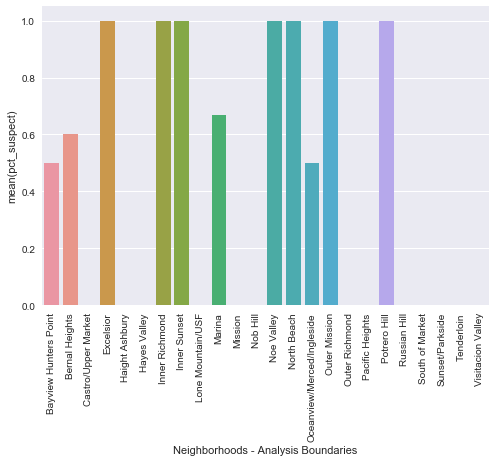

In [12]:
ax = sns.barplot(x='Neighborhoods - Analysis Boundaries', y='pct_suspect', data=grouped)
ax.set_xticklabels(labels=grouped['Neighborhoods - Analysis Boundaries'], rotation=90)
plt.show()

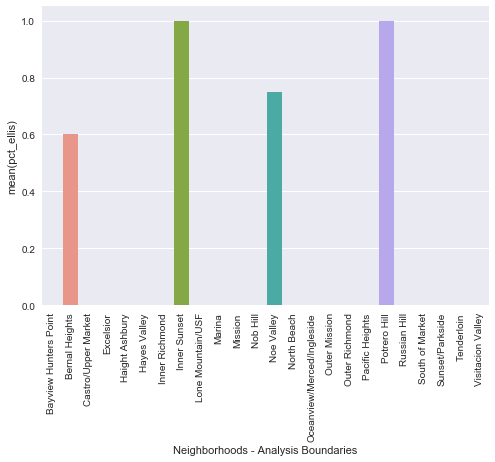

In [13]:
ax = sns.barplot(x='Neighborhoods - Analysis Boundaries', y='pct_ellis', data=grouped)
ax.set_xticklabels(labels=grouped['Neighborhoods - Analysis Boundaries'], rotation=90)
plt.show()

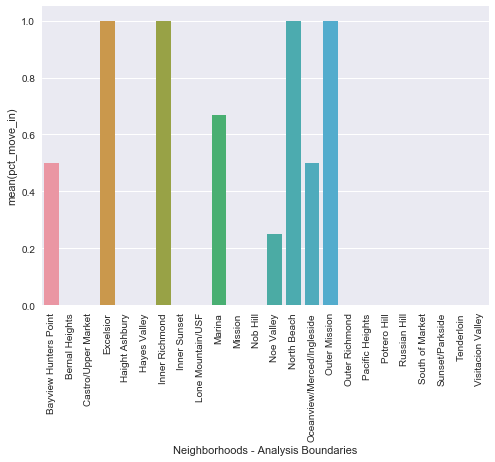

In [14]:
ax = sns.barplot(x='Neighborhoods - Analysis Boundaries', y='pct_move_in', data=grouped)
ax.set_xticklabels(labels=grouped['Neighborhoods - Analysis Boundaries'], rotation=90)
plt.show()